In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib
import glob


In [200]:
# def import_Data():
#     train_df = pd.read_csv('../Data/train.csv')
#     test = pd.read_csv('../Data/test.csv')
#     train, validation = train_test_split(train_df, test_size=0.2)
#     return train, validation, test

# train_df, validation_df, test_df = import_Data()
# train_df.to_csv('../Data/train_df.csv',index=False)
# validation_df.to_csv('../Data/validation_df.csv',index=False)




In [36]:
def visualize(df):
    ## first 5 train rows
    display (df.head())
    ## column info
    print ("df info")
    print (df.info())
    print ("description")
    print (df.describe(include='all'))

    ## Correlation plot between the features
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, square=True, annot=True,ax=ax)
    sns.plt.show()
    
    
    
    #Who had an higher average survival rate? Male or female? The following plot illustrate the proportion of survivors among 
    # male and females. It also shows the average survival rate per sex.
    sns.countplot(x='Sex', hue='Survived', data= df)
    sns.plt.show()
    
    sns.barplot(x='Sex',y='Survived', data= df)
    sns.plt.show()
    
    # we saw female have a better survival rate. What is the effect on class?
    sns.barplot(x='Sex',y='Survived', hue='Pclass', data=df)
    sns.plt.show()
    #As seen from the previous plot female passengers from 1st class have a higher chance of survival than the other classes.
    # This is reiterated by the plot below.
    
    sns.barplot(x='Pclass', y='Survived', data=df)
    sns.plt.show()
    
    # Age column has missing entries. We shall fill it with median
    
    df['Age'].fillna(df['Age'].median(),inplace=True)
    
    sns.distplot(df['Age'])
    sns.plt.show()
    
    # discretizing age into fixed bins and examining th echance of survival based on these bins.
    bins = [0,15,30,45,60,75,90]
    names = ['0-15','15-30','30-45','45-60','60-75','75-90']
    age_groups = pd.cut(df['Age'],bins,labels=names)
    df['Age_groups'] = age_groups
    
    # counting the total number of passengers per age bin. There is only one entry in the age group of 75-90 and the person has surived.
    # This, however does not convey any information on the survival chance at that age group.
    print (pd.value_counts(df['Age_groups']))
    
    sns.barplot(x='Age_groups',y='Survived', data=df)
    sns.plt.show()
    
    # Given a particular age group is more likely to survive, does it have an imapct on the Sex. This is to validate the assumption that 
    # women and children survived to a large extent. AS far as men are concerned Age group 0-15 had the highest chance of survival.
    # Other age groups did not have any significant difference in survival rate.
    sns.barplot(x='Age_groups', y='Survived', hue='Sex', data=df)
    sns.plt.show()
    
    #Relation between the number of siblings and chances of survival. For females there is not a major shift in survival rate with siblings
    # upto 3, over which there is a sharp dip in survival. For men with 1 sibling had higher survival rate.
    sns.barplot(x='SibSp',y='Survived',hue='Sex', data=df)
    sns.plt.show()
    print (pd.value_counts(df['SibSp']))
    
    # A visual evaluation on the obvious effect fo fare on the class with the condition on survived.
    fare_comp_plot = sns.lmplot('Pclass', 'Fare', data=df, hue='Survived', x_jitter=0.5, y_jitter=0.5,
                                    fit_reg=False)
    plt.xticks([1, 2, 3])
    plt.xlabel('Pclass')
    sns.plt.show()
    
    
    #Persons embarked at C has a relatively higher chance of survival. It does not necessary mean anything and could be random.
    sns.barplot(x='Embarked',y='Survived',data=df)
    sns.plt.show()
    
    #C embarkment had higher chance of survival. Is it tied to the Pclass? That is there could be a chance that the total
    # number of persons embarked on C belonging to Pclass=1 could be higher than other thereby weighing down on the survival rate.
    
    sns.barplot(x='Embarked',y='Survived',hue='Pclass',data=df)
    sns.plt.show()
    print ("Number of passengers who embarked at Q with class=1 :",len(df[(df['Embarked']=='Q') & (df['Pclass']==1)]))
    print ("Number of passengers who embarked at Q with class=2 :",len(df[(df['Embarked']=='Q') & (df['Pclass']==2)]))
    # The spike in survival for Q2 does not necesarily convey much with this training data size. There were totally 2 passenger
    # and both survived. It could very well be chance.
    
    # final df structure
    print (df.info())
    


In [37]:
## data preparation
def data_prep(df):
    # Name cannot have any telling on the survival hence dropping
    df.drop('Name', inplace=True,axis=1)
    ## cabin has 163 out of 712 entries so dropping
    df.drop('Cabin', inplace=True, axis=1)
    
    ##passengerId does not seem to have a significance so dropping
    df.drop('PassengerId',axis=1,inplace=True)
   
    # ticket number could  not have much significance with survival. Dropping
    df.drop('Ticket', axis=1, inplace=True)

    # filling missing fare with mean
    df['Fare'].fillna(df['Fare'].mean(),inplace=True)
    
    # filling the missing value with the mode of the column or element with max frequency
    df['Embarked'].fillna(df['Embarked'].mode().iloc[0],inplace=True)
    
    # Age column has missing entries. We shall fill it with median
    
    df['Age'].fillna(df['Age'].median(),inplace=True)
    
    print (df.info())
    
    # converting sex to categorical variable
    df.loc[df['Sex']=='male','Sex'] = 1
    df.loc[df['Sex']=='female','Sex'] = 0
    
    # converting embarked categories to dummies and removing one statistically redundant column. The extra column adds no
    # extra information so removing. In subsequent run, we shall not remove this column and see the impact on score.
    # I expect it to not change much.
    encode = pd.get_dummies(df['Embarked'])

    df.drop('Embarked',axis=1,inplace=True)
    df = df.join(encode)
    df = df.iloc[:,0:-1]
    encode = pd.get_dummies(df['Pclass'])
    df.drop('Pclass',axis=1,inplace=True)
    df = df.join(encode)
    df.drop(3,axis=1,inplace=True)
    display(df.head())
    return df
    

    


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


df info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
description
        PassengerId    Survived      Pclass                Name   Sex  \
count    891.000000  891.000000  891.000000                 891   891   
unique          NaN         NaN         NaN                 891     2   
top             NaN         NaN         NaN  Richard, Mr. Emile  male   
freq            NaN         NaN         NaN                   1   577   
mean     446.000000    0.

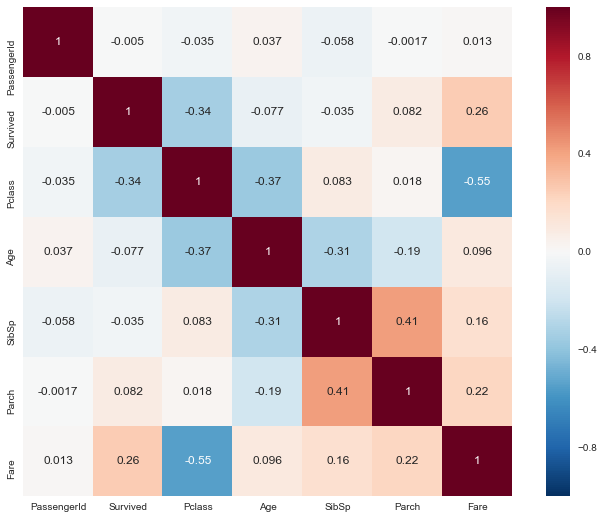

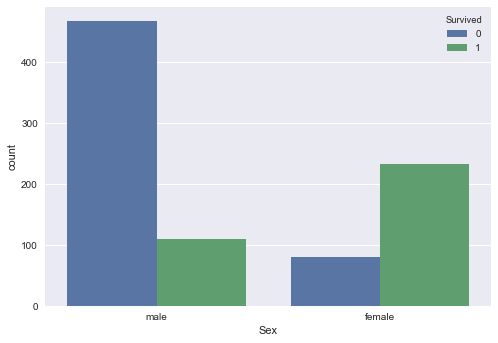

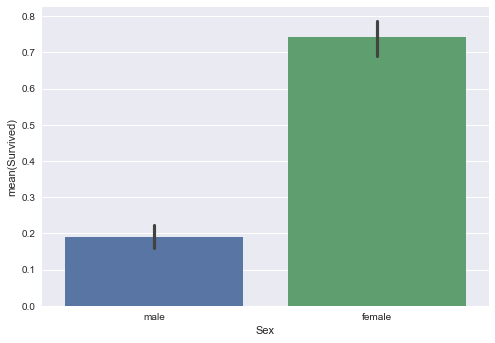

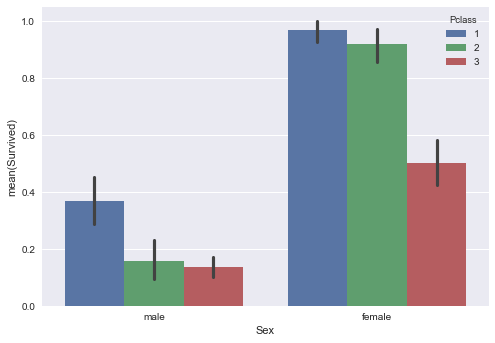

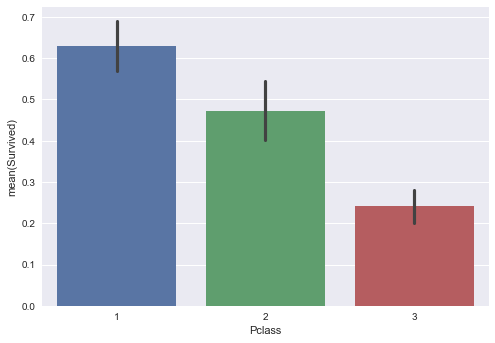

C:\Users\prath\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


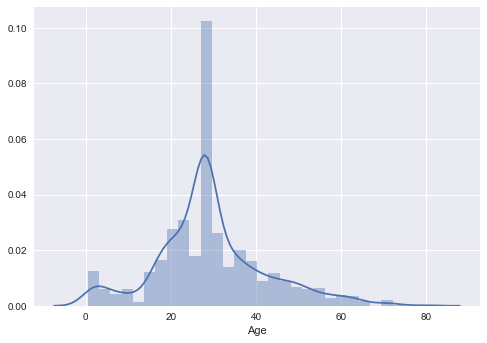

15-30    503
30-45    202
0-15      83
45-60     81
60-75     21
75-90      1
Name: Age_groups, dtype: int64


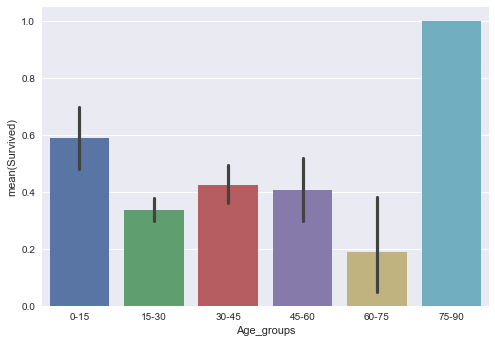

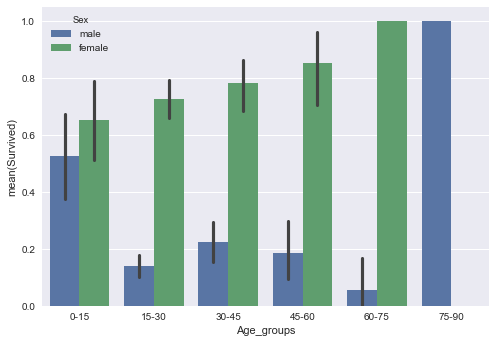

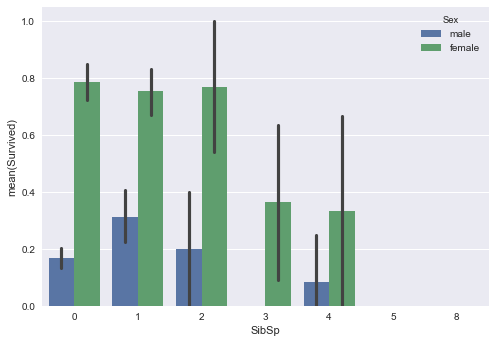

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


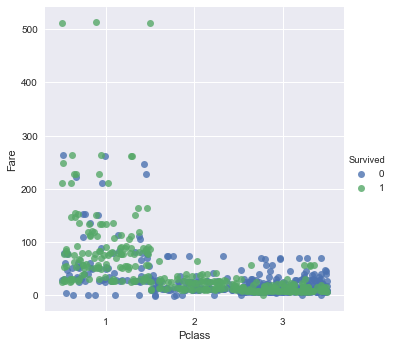

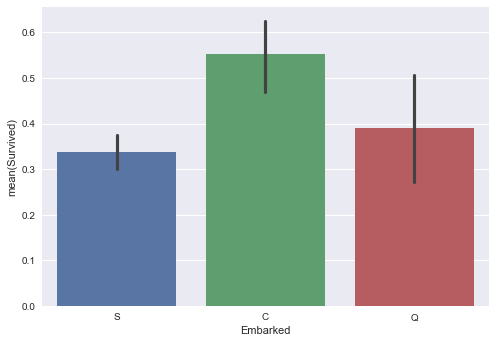

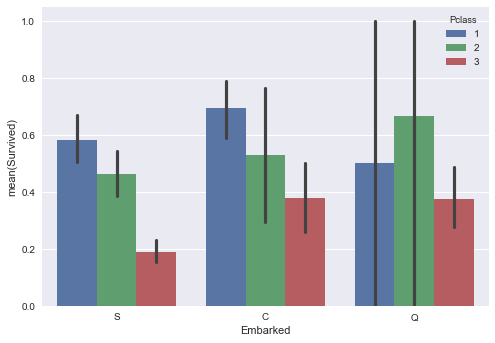

Number of passengers who embarked at Q with class=1 : 2
Number of passengers who embarked at Q with class=2 : 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Age_groups     891 non-null category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 84.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
Age         1309 non-null float64
Embarked    1309 non-null object
Fare        1309 non-null float64
Parch       1309 non-null int64
Pclass   

,Age,Fare,Parch,Sex,SibSp,Survived,C,Q,1,2
0,22.0,7.2500,0,1,1,0.0,0,0,0,0
1,38.0,71.2833,0,0,1,1.0,1,0,1,0
2,26.0,7.9250,0,0,0,1.0,0,0,0,0
3,35.0,53.1000,0,0,1,1.0,0,0,1,0
4,35.0,8.0500,0,1,0,0.0,0,0,0,0


,Age,Fare,Parch,Sex,SibSp,C,Q,1,2,Survived
0,22.0,7.2500,0,1,1,0,0,0,0,0.0
1,38.0,71.2833,0,0,1,1,0,1,0,1.0
2,26.0,7.9250,0,0,0,0,0,0,0,1.0
3,35.0,53.1000,0,0,1,0,0,1,0,1.0
4,35.0,8.0500,0,1,0,0,0,0,0,0.0


In [38]:
## feature selection and model pipeline
    
    
def runner():
    train = pd.read_csv('../Data/train.csv')
    test = pd.read_csv('../Data/test.csv')
    data_full = train.append(test,ignore_index=True)
    visualize(train)
    prep_data = data_prep(data_full)
    col_data = prep_data.columns.tolist()
    col_new = ['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'C', 'Q',1,2, 'Survived']
    prep_data = prep_data[col_new]
    train_df = prep_data[:train.shape[0]]
    test_df = prep_data[train.shape[0]:]
    display(train_df.head())
    train_df.to_csv('../Data/train_df.csv')
    test_df.to_csv('../Data/test_df.csv')
    #build(train_df,test_df)
    
    
    

runner()
    



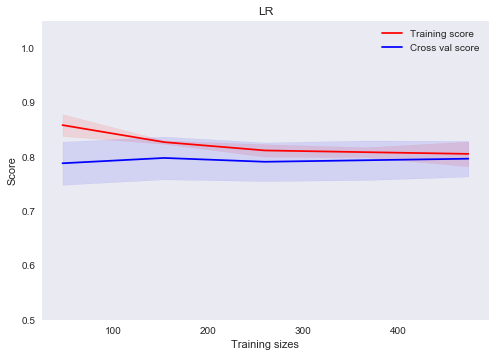

---------------------- LR ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.81      0.90      0.85       108
 Survived 1       0.81      0.68      0.74        71

avg / total       0.81      0.81      0.81       179

----------------------------------------------------
---------------------- LR ---------------------


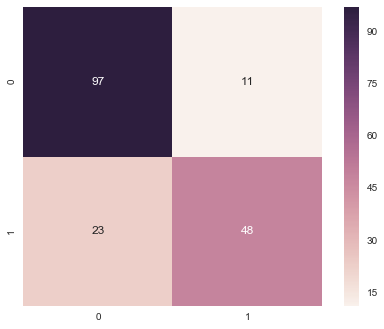

Accuracy score: 0.810055865922
----------------------------------------------------


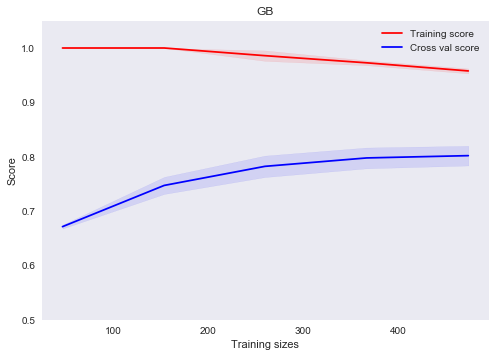

---------------------- GB ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.81      0.94      0.87       108
 Survived 1       0.87      0.66      0.75        71

avg / total       0.83      0.83      0.82       179

----------------------------------------------------
---------------------- GB ---------------------


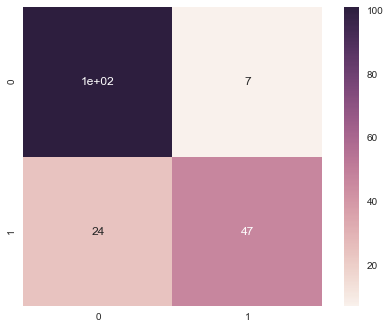

Accuracy score: 0.826815642458
----------------------------------------------------


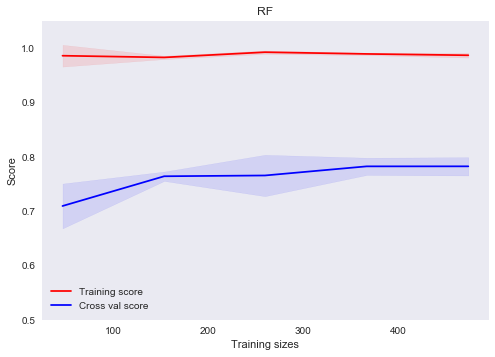

---------------------- RF ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.81      0.95      0.88       108
 Survived 1       0.90      0.66      0.76        71

avg / total       0.85      0.84      0.83       179

----------------------------------------------------
---------------------- RF ---------------------


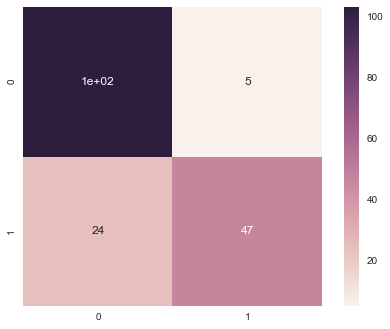

Accuracy score: 0.837988826816
----------------------------------------------------


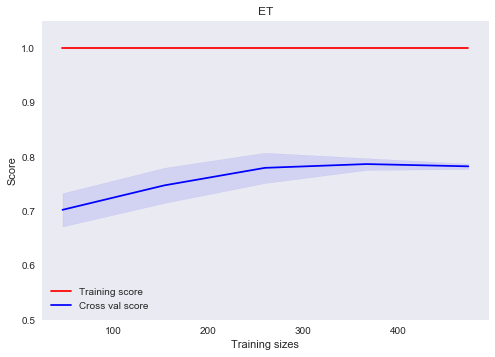

---------------------- ET ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.82      0.93      0.87       108
 Survived 1       0.86      0.69      0.77        71

avg / total       0.84      0.83      0.83       179

----------------------------------------------------
---------------------- ET ---------------------


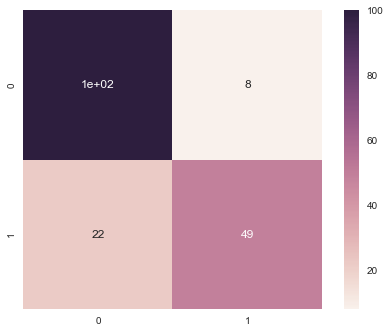

Accuracy score: 0.832402234637
----------------------------------------------------


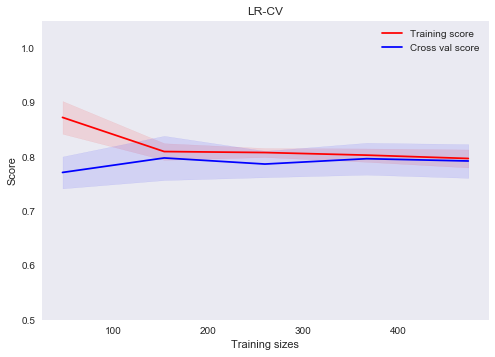

Dumping models
---------------------- LR-CV ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.81      0.87      0.84       108
 Survived 1       0.78      0.69      0.73        71

avg / total       0.80      0.80      0.80       179

----------------------------------------------------
---------------------- LR-CV ---------------------


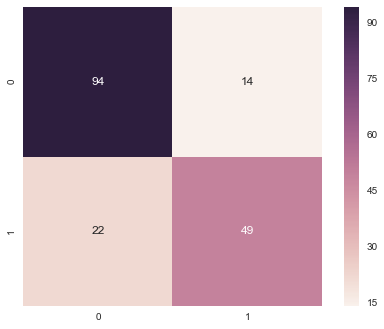

Accuracy score: 0.798882681564
----------------------------------------------------


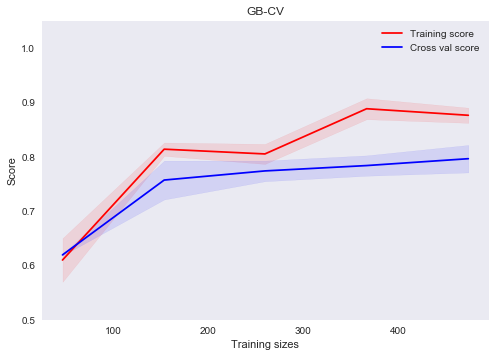

Dumping models
---------------------- GB-CV ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.82      0.90      0.86       108
 Survived 1       0.82      0.70      0.76        71

avg / total       0.82      0.82      0.82       179

----------------------------------------------------
---------------------- GB-CV ---------------------


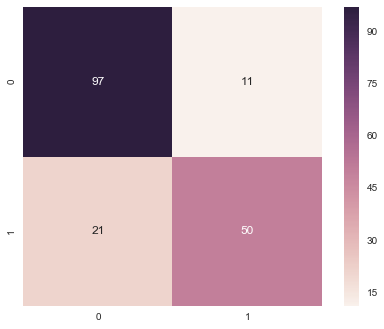

Accuracy score: 0.821229050279
----------------------------------------------------


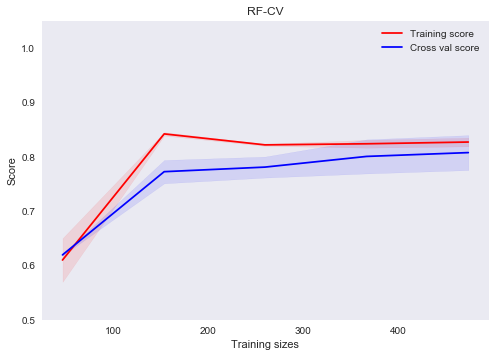

Dumping models
---------------------- RF-CV ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.84      0.89      0.86       108
 Survived 1       0.82      0.75      0.78        71

avg / total       0.83      0.83      0.83       179

----------------------------------------------------
---------------------- RF-CV ---------------------


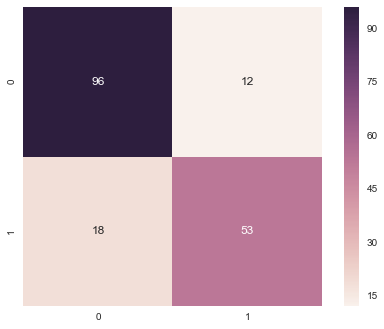

Accuracy score: 0.832402234637
----------------------------------------------------


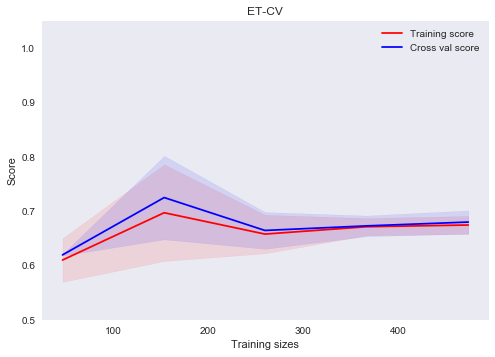

Dumping models
---------------------- ET-CV ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.69      0.99      0.82       108
 Survived 1       0.96      0.34      0.50        71

avg / total       0.80      0.73      0.69       179

----------------------------------------------------
---------------------- ET-CV ---------------------


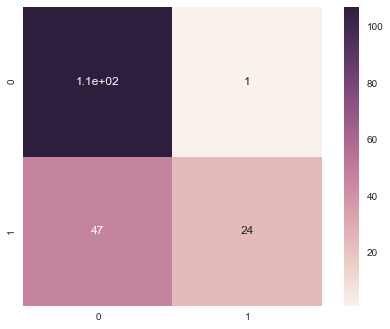

Accuracy score: 0.731843575419
----------------------------------------------------
----Submission No vote----


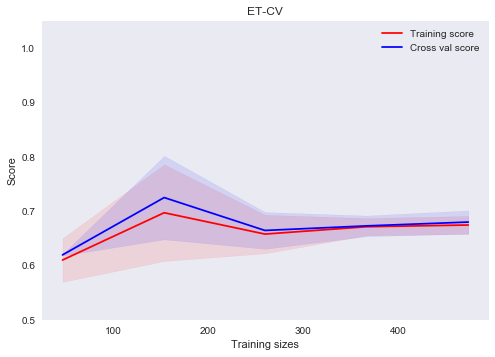

Dumping models
---------------------- Voting ---------------------
             precision    recall  f1-score   support

  Suvived 0       0.82      0.90      0.86       108
 Survived 1       0.82      0.70      0.76        71

avg / total       0.82      0.82      0.82       179

----------------------------------------------------
---------------------- Voting ---------------------


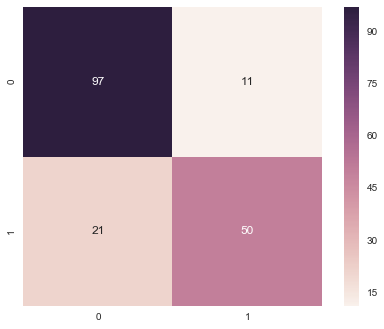

Accuracy score: 0.821229050279
----------------------------------------------------
----Submission vote----


In [58]:
def build(train_df,test_df):
    train_x,valid_x,train_y,valid_y = train_test_split(train_df.iloc[:,0:-1],train_df.Survived,train_size=0.8,random_state=365)
    
    random_state = 43245

    # A pipeline of three models with PCA transformation
    pipes=[]
    pipe2 = Pipeline([
        ('pca',PCA()), ('LR',LogisticRegression(random_state=random_state))
    ])
    
    pipe3 = Pipeline([
        ('pca',PCA()), ('gBoost',GradientBoostingClassifier(random_state=random_state))
    ])
    
    pipeRF = Pipeline([('pca',PCA()),('RF',RandomForestClassifier(random_state=random_state))])
    
    
    pipeETree = Pipeline([('pca',PCA()),('ET',ExtraTreesClassifier(random_state=random_state))])
    
    ## PCA feature transformation is applied in all three models followed by Svm, LR and gBoost estimators in each pipeline.
    # Initially would like to see how each model compares against each other
    
    pipes.append(pipe2)
    pipes.append(pipe3)
    pipes.append(pipeRF)
    pipes.append(pipeETree)
    
    classifier_name = ['LR','GB','RF','ET']
    
    for i in range(len(pipes)):
        y_pred_valid = model_construct(pipes[i], train_x, train_y, valid_x,classifier_name[i])
        print_report(y_pred_valid,valid_y,classifier_name[i])
        print_confusion(y_pred_valid,valid_y,classifier_name[i])
    
    
    param_grid_lr = [{
        'pca__n_components':[2,4,8],
        'LR__C':[0.01,0.1,1,10,100]
    }]
    
    param_grid_gb = [{
        'pca__n_components':[2,4,8],
        'gBoost__max_depth':[3],
        'gBoost__learning_rate':[0.1,0.15,0.2],
        'gBoost__n_estimators':[20,50,100],
        'gBoost__min_samples_split':[35,50,70],
        'gBoost__min_samples_leaf':[50]
    }]
    
    param_grid_RF = [{
        'pca__n_components':[2,4,8],
        'RF__max_depth':[3],
        'RF__min_samples_split':[35,50,70]
    }]
    
    param_grid_ET = [{
        'pca__n_components':[2,4,8],
        'ET__max_depth':[3,5,8],
        'ET__min_samples_split':[35,50],
        'ET__min_samples_leaf':[30,50,70]
    }]
    
    classifier_name = ['LR-CV','GB-CV','RF-CV','ET-CV']
    params = [param_grid_lr,param_grid_gb,param_grid_RF,param_grid_ET]
    for i in range(len(pipes)):
        y_pred_valid = model_construct(pipes[i], train_x, train_y, valid_x,classifier_name[i],grid_Param=params[i])
        print_report(y_pred_valid,valid_y,classifier_name[i])
        print_confusion(y_pred_valid,valid_y,classifier_name[i])
    
    
    print("----Submission No vote----")
    test_x = test_df.iloc[:,:-1]
    y_pred_submit = model_construct(pipes[3],train_x,train_y,test_x,'ET-CV',grid_Param=params[3])
    passengerId  = pd.read_csv('../Data/Test.csv')['PassengerId']
    submission_df = pd.DataFrame({'PassengerId':passengerId,'Survived':y_pred_submit})
    submission_df.to_csv('../Data/gender_submission_novote.csv',index=False)
    
    
    build_voter(train_x,train_y,valid_x,valid_y,test_x)
   
 
def build_voter(train_x,train_y,valid_x,valid_y,test_x):
    
    model_files = glob.glob('./*.pkl')
    estimators = []
    weights=[]
    for file in model_files:
        estimators.append((file,joblib.load(file)))


    votingClass = VotingClassifier(estimators=estimators,voting='soft',weights=[2,2,1,3])

    
    votingClass.fit(train_x,train_y)
    y_pred_valid = votingClass.predict(valid_x)
    print_report(y_pred_valid,valid_y,'Voting')
    print_confusion(y_pred_valid,valid_y,'Voting')
    y_pred_submit = votingClass.predict(test_x)

    print("----Submission vote----")
    passengerId  = pd.read_csv('../Data/Test.csv')['PassengerId']
    submission_df = pd.DataFrame({'PassengerId':passengerId,'Survived':y_pred_submit})
    submission_df.to_csv('../Data/gender_submission_vote.csv',index=False)
    ## Final score in kaggle submission 0.779

def model_construct(pipe, X, Y, test_X, name, **param):
    grid_Param = None
    if ('grid_Param' in param):
        grid_Param = param['grid_Param']
    
    if (grid_Param is None):
        pipe.fit(X,Y)
        plot_learning_curve(pipe,X,Y,name)
        predicted_Y = pipe.predict(test_X)
    else:
        fileName = name+'.pkl'
        grid = GridSearchCV(estimator=pipe,param_grid=grid_Param,scoring='accuracy',cv=5)
        plot_learning_curve(grid,X,Y,name)
        grid.fit(X,Y)
        print ("Dumping models")
        joblib.dump(grid,filename=fileName,compress=3)
        predicted_Y = grid.predict(test_X)
    
    return predicted_Y
    
    
    

def plot_learning_curve(estimator,X,Y,title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=3, n_jobs=1, train_sizes= np.linspace(0.1, 1.0, 5))
    train_score_mean = np.mean(train_scores,axis=1)
    test_score_mean = np.mean(test_scores,axis=1)
    train_score_std = np.std(train_scores,axis=1)
    test_score_std = np.std(test_scores,axis=1)
    plt.figure()
    plt.title(title)
    plt.grid()
    plt.ylim(0.5,1.05)
    plt.fill_between(train_sizes,train_score_mean-train_score_std,train_score_mean+train_score_std,alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_score_mean-test_score_std,test_score_mean+test_score_std,alpha=0.1,color='b')
    plt.plot(train_sizes,train_score_mean,color='r',label='Training score')
    plt.plot(train_sizes,test_score_mean,color='b',label='Cross val score')
    plt.xlabel('Training sizes')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()
    
    

def print_report(y_pred,y_true,name):
    target_Names = ['Suvived 0', 'Survived 1']
    print ('----------------------',name,'---------------------')
    print (classification_report(y_true,y_pred,target_names=target_Names))
    print('----------------------------------------------------')
    
def print_confusion(y_pred,y_true,name):
    labels = [0, 1]
    print ('----------------------',name,'---------------------')
    conf_mat =  confusion_matrix(y_true,y_pred,labels=labels)
    sns.heatmap(conf_mat,annot=True,square=True)
    sns.plt.show()
    print ("Accuracy score:",accuracy_score(y_true,y_pred))
    print('----------------------------------------------------')
    
    
    
def builder():
    train_df = pd.read_csv('../Data/train_df.csv')
    test_df = pd.read_csv('../Data/test_df.csv')
    build(train_df,test_df)
                                                      
builder()                                                    
                                                      
                                                      
                                                      
                                                      
                               
    